###  MicroGrad demo

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline


In [50]:
def f(x):
    return 3*x**2 - 4*x + 5

In [54]:
f(3.0)

20.0

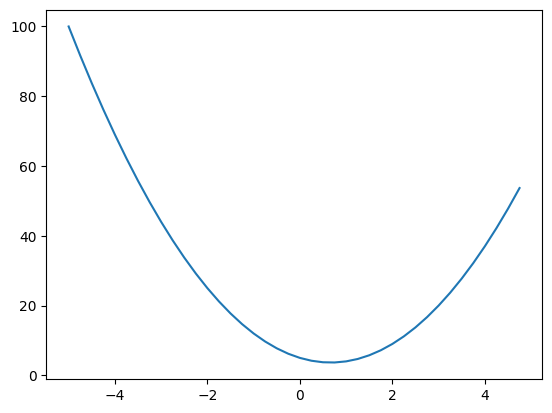

In [56]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [62]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [64]:
#lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [68]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [21]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            #! importatn
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            #! importatn
            self.grad += other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            #! importatn
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            #! importatn
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            #! importatn
            self.grad = +out.data * out.grad
        out._backward = _backward
        return out
     
    def backward(self):
        # maping the from 'o' to 'x1w1' and 'x2w2'  
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

            

Value(data=3.5)

In [22]:
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        #connect n1 to the op node n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


In [23]:
draw_dot(L)

NameError: name 'L' is not defined

In [185]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2

In [ ]:
# derivative for 'f' and 'd'
L = d * f

dL/dd = f
dL/df = d

(f(x + h) - f(x))/h
(fx + fh - fx)/h
fh/h
f

# derivative for 'c' and 'e' op '+' is 1
d = c + e

dd/dc = 1.0
dd/de = 1.0

Chain rule:

want:
dL/dc = (dL/dd) * (dd/dc)


know:
dL/dd
dd/dc

#! if '+' passes the gradient of sum to childs
#! if '*' operation we switch values to each other gradient

dL/de = -2.0

e = a * b

de/da = b
de/db = a

dL/da = (dL/de) * (de/da)
dL/db = (dL/de) * (de/db)



In [11]:
def lol():
    h = 0.001

    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0); f.label = 'f'
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2 , label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a * b; e.label = 'e'
    # e.data += h
    d = e + c; d.label = 'd'
    # d.data += h
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

0.0


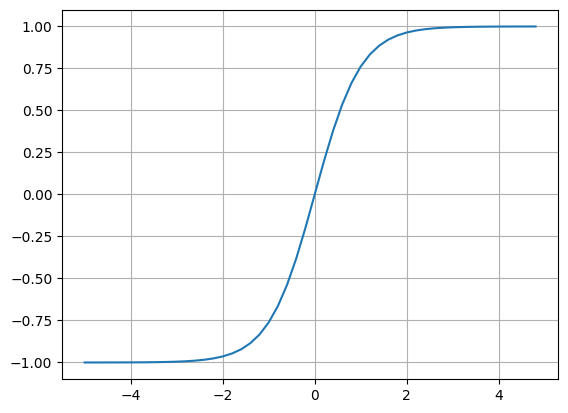

In [12]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [13]:
#inputs x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#input weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + d neuron formula
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

#output tenh
o = n.tanh(); o.label='o'

# o.backward()



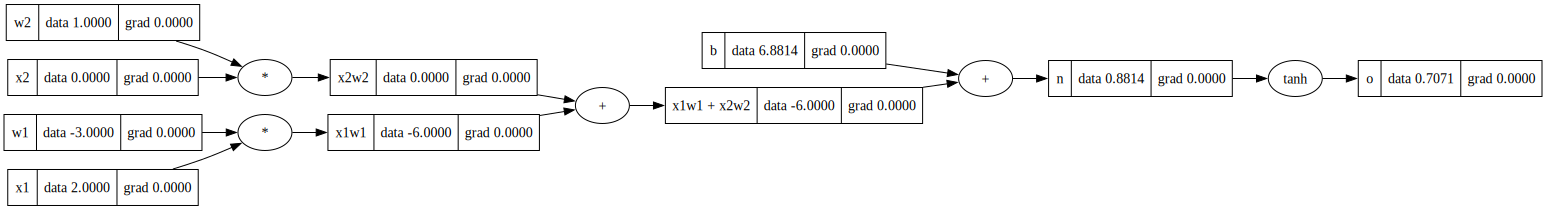

In [14]:
draw_dot(o)

In [234]:
o.grad = 1.0

In [236]:
o._backward()

In [238]:
n._backward()

In [240]:
b._backward()
x1w1x2w2._backward()

In [244]:
x2w2._backward()
x1w1._backward()

In [266]:
o.backward()

In [ ]:
# o = tanh(n)
# do/dn = 1 - o**2
# Manual Backward

In [204]:
o.grad = 1.0

In [206]:
n.grad = 1 - o.data**2

In [208]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [210]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [219]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [217]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

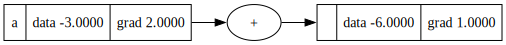

In [279]:
#bugs for the Backward funstion (wrong grad) overwriting gradience

a = Value(-3.0, label='a')
b = a + a

b.backward()
draw_dot(b)

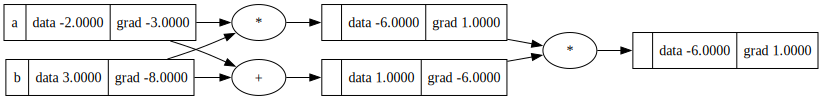

In [278]:
#bugs for the Backward funstion overwriting gradience
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
e = a + b
f = d * e

f.backward()
draw_dot(f)

In [437]:
#inputs x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#input weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + d neuron formula
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

# --------- 
e = (2*n).exp()
# o = (e - 1) / (e + 1)
# -------------------------

#output tenh
# o = n.tanh(); 
# o.label='o'

# o.backward()
# draw_dot(o)



In [16]:
import torch

In [17]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


print(o.data.item())
o.backward()

print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [18]:
from typing import Any


class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)))
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    # nin - demetionality nout - number of neurons
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    # nouts - sizes of all neurons
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
# x = [2.0, 3.0]
# n = Layer(2,4)
# n(x)
    
x = [2.0, 3.0, -1.0]
# 3 inputs 2 
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.3349112674989521)

In [26]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired target
ypred = [n(x) for x in xs]
ypred


[Value(data=-0.3349112674989521),
 Value(data=-0.21204881202701248),
 Value(data=-0.27871137509053256),
 Value(data=-0.10540402549452382)]

In [ ]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

In [ ]:
loss.backward()

In [28]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [29]:
np.random.seed(1337)
random.seed(1337)

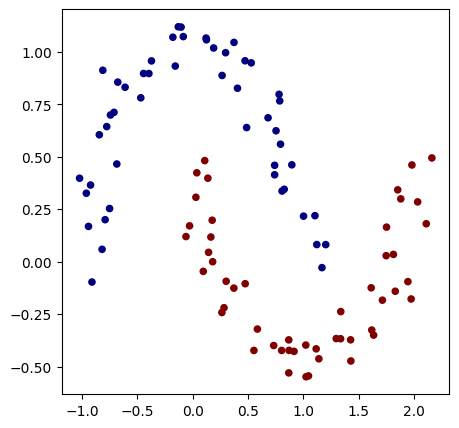

In [31]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [32]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [33]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [ ]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584198, accuracy 82.0%
step 4 loss 0.3692793385976538, accuracy 84.0%
step 5 loss 0.313545481918522, accuracy 86.0%
step 6 loss 0.2814234349772435, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.2704862551637922, accuracy 91.0%
step 10 loss 0.24507023853658053, accuracy 91.0%
step 11 loss 0.2509905529791503, accuracy 92.0%
step 12 loss 0.21560951851922952, accuracy 91.0%
step 13 loss 0.23090378446402726, accuracy 93.0%
step 14 loss 0.20152151227899445, accuracy 92.0%
step 15 loss 0.22574506279282217, accuracy 93.0%
step 16 loss 0.19447987596204114, accuracy 92.0%
step 17 loss 0.21089496199246363, accuracy 93.0%
step 18 loss 0.159830773563036, accuracy 94.0%
step 19 loss 0.1845374874688392, accuracy 93.0%
step 20 loss 0.18977522856087634, accuracy 9

(-1.548639298268643, 1.951360701731357)

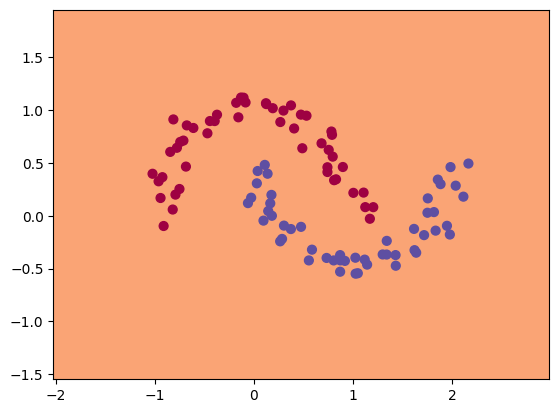

In [34]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
